Needed Imports

In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

5.2 Loading augmented images to tensorflow dataset

In [3]:
# Reuse code from imagePreparing
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\faces\\train_faces\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
# resizing the images to have less data going through the model later on
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
# we also scale the images to have values between 0 and 1
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('aug_data\\faces\\test_faces\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
# resizing the images to have less data going through the model later on
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
# we also scale the images to have values between 0 and 1
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('aug_data\\faces\\val_faces\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
# resizing the images to have less data going through the model later on
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
# we also scale the images to have values between 0 and 1
val_images = val_images.map(lambda x: x/255)

## 6. Perparing the labels

6.1 Build label loading function

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

6.2 Load labels to tensorflow dataset

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\faces\\train_faces\\labels\\*.json', shuffle=False)
#  py_function to give the full label_path to the load_labels function
train_labels =  train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('aug_data\\faces\\test_faces\\labels\\*.json', shuffle=False)
#  py_function to give the full label_path to the load_labels function
test_labels =  test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('aug_data\\faces\\val_faces\\labels\\*.json', shuffle=False)
#  py_function to give the full label_path to the load_labels function
val_labels =  val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2041, 0.2666, 0.651 , 0.8584], dtype=float16))

## 7. Combine lables and images

7.1 Checking the partition lengths

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6480, 6480, 1260, 1260, 1560, 1560)

7.2 Create final datasets (images/labelsx

In [13]:
# zip to match image and label
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000) # shuffle with value higher than shape of images
train = train.batch(8) # split in batches of 8
train = train.prefetch(4) # prefetch for performance

In [14]:
# zip to match image and label
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1400) # shuffle with value higher than shape of images
test = test.batch(8) # split in batches of 8
test = test.prefetch(4) # prefetch for performance

In [15]:
# zip to match image and label
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1700) # shuffle with value higher than shape of images
val = val.batch(8) # split in batches of 8
val = val.prefetch(4) # prefetch for performance

In [16]:
# we should get 8 (batch) images in one time
train.as_numpy_iterator().next()[0].shape # shape gets (8, 120, 120, 3) ==> 8 images 120 pix heigth 120 pix width 3 full color
train.as_numpy_iterator().next()[1] # label

(array([[0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.669 , 0.0864, 0.979 , 0.4868],
        [0.3354, 0.4539, 0.575 , 0.667 ],
        [0.2502, 0.2988, 0.7793, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.4448, 0.3594, 0.9336, 0.98  ]], dtype=float16))

7.3 View augmented images and annotations

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


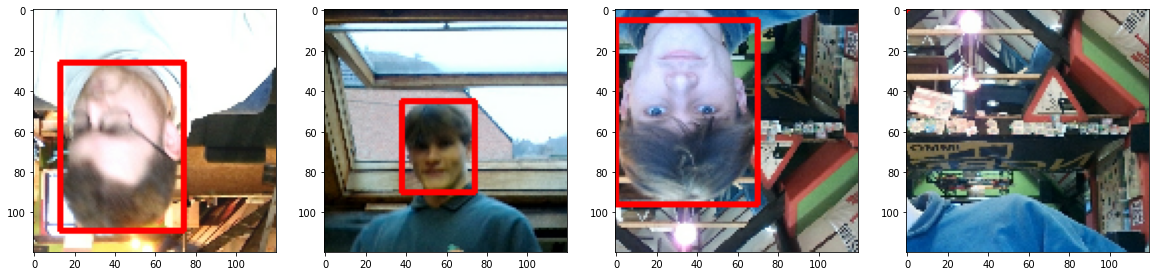

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Building Deep Learning model 

8.1 Import layers and base network

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D 
from tensorflow.keras.applications import VGG16

8.2 Download VGG16

In [21]:
# Don't need the top of the VGG16 model
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

8.3 Build instance of network

In [23]:
def build_model(): 
    # input shape = image resolution
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg) # Only returning the max values 
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg) # Only returning the max values 
    regression1 = Dense(2048, activation='relu')(f2)
    regression2 = Dense(4, activation='sigmoid')(regression1)
    
    # Two outputs: classification output and regression output (just like the annotations)
    # class 2 = 1 output between 0 and 1 (sigmoid)
    # regression 2 = 4 outputs between 0 and 1 (sigmoid)
    tracker = Model(inputs=input_layer, outputs=[class2, regression2])
    return tracker

In [24]:
#  Two ouputs just like the annotations
train.as_numpy_iterator().next()[1] # first array = classification, second array = regression

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.0932 , 0.     , 0.629  , 0.701  ],
        [0.371  , 0.5815 , 0.623  , 0.859  ],
        [0.     , 0.2986 , 0.1777 , 0.9214 ],
        [0.6294 , 0.3462 , 0.986  , 0.7964 ],
        [0.     , 0.3262 , 0.2773 , 0.947  ],
        [0.1826 , 0.05035, 0.639  , 0.6587 ],
        [0.542  , 0.2776 , 1.     , 0.9917 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

8.4 Test model

In [25]:
facetracker = build_model()

In [26]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [27]:
# Testing out 1 sample
X, y = train.as_numpy_iterator().next()

In [28]:
# 1 batch
X.shape

(8, 120, 120, 3)

In [29]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [30]:
# After training we want predictions like htis
classes, coords

(array([[0.5002965 ],
        [0.55896723],
        [0.40288007],
        [0.45049182],
        [0.5804549 ],
        [0.45963413],
        [0.567561  ],
        [0.5771188 ]], dtype=float32),
 array([[0.44419742, 0.6768189 , 0.5617686 , 0.3095432 ],
        [0.45874202, 0.6551185 , 0.46141216, 0.25266033],
        [0.52915215, 0.6621132 , 0.5934733 , 0.3493253 ],
        [0.4811743 , 0.7061748 , 0.55576605, 0.3000415 ],
        [0.4257288 , 0.69267225, 0.42328382, 0.26275992],
        [0.5206672 , 0.694813  , 0.55463946, 0.35836232],
        [0.4209414 , 0.6847292 , 0.65107065, 0.31679475],
        [0.4111267 , 0.68079287, 0.6695474 , 0.32841286]], dtype=float32))

## 9. Define Losses and Optimizers

9.1 Define optimizers and learning rate

In [31]:
# get amount of batches in training set
batches = len(train)
batches

810

In [32]:
batches_per_epoch = batches
# how to decrease the learning rate so we do not overfit
learning_rate_decay = (1./0.75 - 1)/batches_per_epoch

In [33]:
# Set optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=learning_rate_decay)

9.2 Localization loss and classification loss

In [34]:
def localization_loss(y_true, yhat):
    # dst between coordinates 
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    # actual height and actual width box          
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    # predicted height and predicted width of box
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    # diff between sizes
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [35]:
# Defining class loss and regression loss
class_loss =  tf.keras.losses.BinaryCrossentropy()
regression_loss = localization_loss

9.3 Test out loss metrics

In [36]:
#  Test localization loss on predicted value of 8.4
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.628035>

In [37]:
class_loss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67610395>

In [38]:
# Should be the same as localization_loss
regression_loss(y[1], coords)   

<tf.Tensor: shape=(), dtype=float32, numpy=9.628035>

## 10. Train Neural Network

10.1 Custom model class

In [39]:
class FaceTracker(Model): 
    # Self.model equals facetracker
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    # Pass loss and optimizer in compile method
    def compile(self, opt, class_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.closs = class_loss
        self.lloss = localization_loss
        self.opt = opt
    
    # Takes one batch of data and trains it (this function trains the neural network!)
    def train_step(self, batch, **kwargs): 
        
        # Unpack batch in it's X and y values
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True) # make pred via the model + training =True
            
            # Take classes and coords and pass them through the loss functions (y_true, y_pred)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # Put losses together to get 1 total loss
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            # Calculate gradients with respect to the loss functions
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        # Return dict with all losses so we can evaluate later on
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    # Same as train_step but for the val and test set (only returning losses)
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [40]:
#  Pass neural network to the Facetracker class
model = FaceTracker(facetracker)

In [41]:
model.compile(optimizer, class_loss, regression_loss)

10.2 Train

In [42]:
log_dir='logs'

In [43]:
# Logging tensorboard working to log dir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [44]:
# Fit method will trigger train_step function
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
810/810 [==============================] - 57s 63ms/step - total_loss: 0.2833 - class_loss: 0.0716 - regress_loss: 0.2475 - val_total_loss: 0.2485 - val_class_loss: 0.1377 - val_regress_loss: 0.1796
Epoch 2/10
810/810 [==============================] - 49s 55ms/step - total_loss: 0.0862 - class_loss: 0.0245 - regress_loss: 0.0740 - val_total_loss: 0.6804 - val_class_loss: 0.5200 - val_regress_loss: 0.4204
Epoch 3/10
810/810 [==============================] - 49s 55ms/step - total_loss: 0.0597 - class_loss: 0.0170 - regress_loss: 0.0512 - val_total_loss: 0.0221 - val_class_loss: 6.6519e-05 - val_regress_loss: 0.0220
Epoch 4/10
810/810 [==============================] - 48s 54ms/step - total_loss: 0.0377 - class_loss: 0.0117 - regress_loss: 0.0318 - val_total_loss: 0.0273 - val_class_loss: 9.0459e-04 - val_regress_loss: 0.0269
Epoch 5/10
810/810 [==============================] - 49s 55ms/step - total_loss: 0.0261 - class_loss: 0.0076 - regress_loss: 0.0223 - val_total_loss: 1

10.3 Plot performance

In [45]:
# Check on all values of the training
hist.history

{'total_loss': [1.2934926748275757,
  0.012246477417647839,
  0.008641650900244713,
  0.005661274306476116,
  0.5791450142860413,
  0.010501519776880741,
  0.00498232152312994,
  0.004679461941123009,
  0.01905694790184498,
  0.0038725403137505054],
 'class_loss': [0.25238823890686035,
  0.00017865767586044967,
  9.238837265002076e-06,
  0.00010103784734383225,
  0.1692863553762436,
  0.001361211994662881,
  0.00012982194311916828,
  5.5730738495185506e-06,
  0.0062694186344742775,
  0.0005681796465069056],
 'regress_loss': [1.1672985553741455,
  0.01215714868158102,
  0.00863703154027462,
  0.005610755179077387,
  0.49450182914733887,
  0.009820913895964622,
  0.004917410667985678,
  0.004676675423979759,
  0.015922239050269127,
  0.0035884506069123745],
 'val_total_loss': [0.2484724521636963,
  0.6803891062736511,
  0.022067241370677948,
  0.027347009629011154,
  1.2958117723464966,
  0.019624682143330574,
  0.016704868525266647,
  0.010464327409863472,
  0.04378896951675415,
  0.007

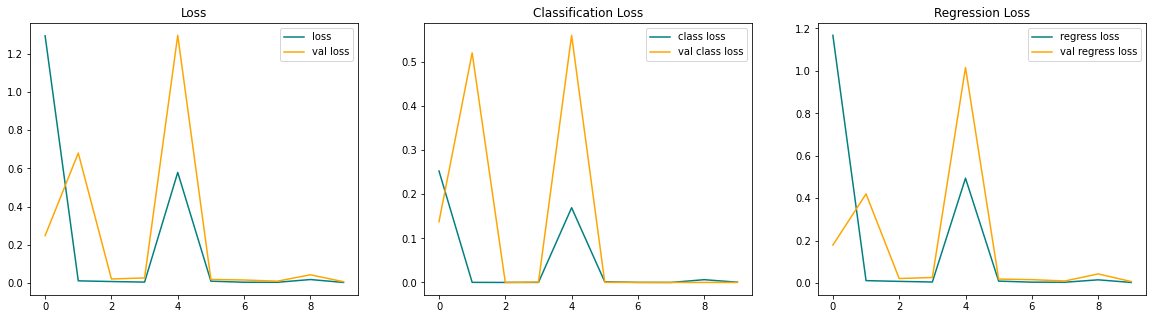

In [46]:
# Plotting Total loss, Classification loss and regression loss to spot rare values
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

11.1 Predictions on test set

In [47]:
# Setup iterator
test_data = test.as_numpy_iterator()

In [51]:
# Grab one batch of data
test_sample = test_data.next()

In [52]:
# Do a prediction
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


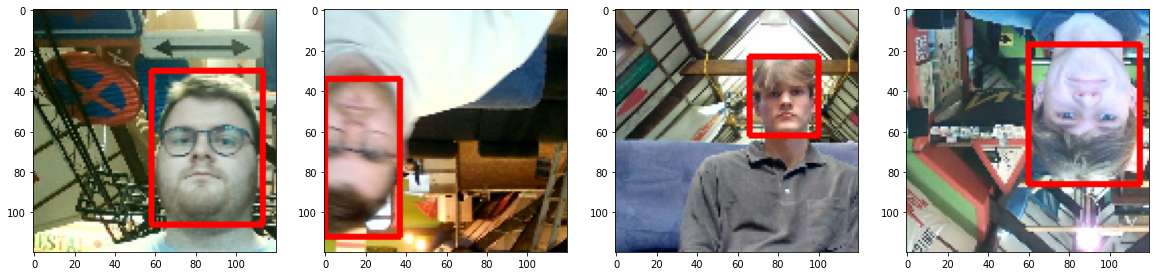

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # If classification loss is over 0.9 plot the rectangle 
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

11.2 Save the model

In [54]:
facetracker.save('facetracker_v2.h5')